In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math
import seaborn as sns
import string
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
import statistics
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding, Input
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")


In [284]:
df1=pd.read_csv(r'C:\Users\Krist\OneDrive\Desktop\d213 task 2\imdb_labelled.txt', sep='\t', header=None, names =['Review', 'Rating'])
df2=pd.read_csv(r'C:\Users\Krist\OneDrive\Desktop\d213 task 2\amazon_cells_labelled.txt', sep='\t', header=None, names =['Review', 'Rating'])
df3=pd.read_csv(r'C:\Users\Krist\OneDrive\Desktop\d213 task 2\yelp_labelled.txt', sep='\t', header=None, names =['Review', 'Rating'])


In [285]:
df=pd.concat([df1, df2, df3], axis=0)

In [286]:
df.head()

,Review,Rating
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [287]:
df.isnull().sum()

Review    0
Rating    0
dtype: int64

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

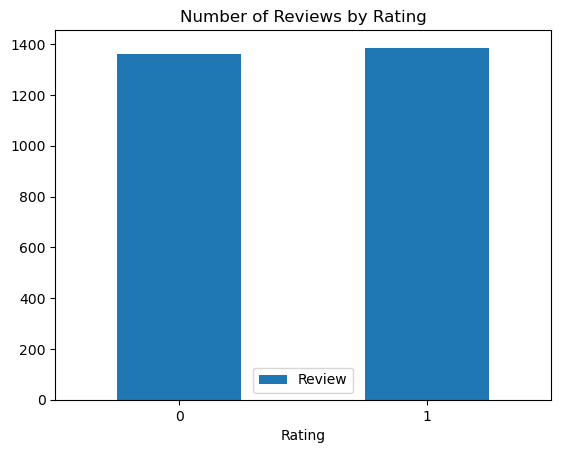

In [288]:
ax=df.groupby('Rating').count().plot.bar(ylim=0)
ax.set_title('Number of Reviews by Rating')
plt.xticks(rotation=0)

In [289]:
#Code from Analytics Vidhya
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['Review']=df['Review'].apply(lambda x:expand_contractions(x))


In [290]:
#all lower case letters
df['Review']=df['Review'].apply(lambda x: x.lower())

In [291]:
#remove punctuation
df['Review']=df['Review'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

In [292]:
#remove extra spaces
df['Review']=df['Review'].apply(lambda x: re.sub(' +',' ',x))

In [293]:
#change numbers within the strings of text from numerical to XXXX representation
# Mapping dictionary for integer to word conversion
mapping_dict = {
    '0': 'zero',
    '1': 'one',
    '2': 'two',
    '3': 'three',
    '4': 'four',
    '5':'five',
    '6': 'six',
    '7': 'seven',
    '8': 'eight',
    '9': 'nine',
    '10': 'ten'
}

# Function to replace integers with words
def replace_integers_with_words(text):
    for key, value in mapping_dict.items():
        text = re.sub(r'\b' + key + r'\b', value, text)
    return text

# Convert integers to words in the 'Review' column
df['Review'] = df['Review'].apply(replace_integers_with_words)


In [294]:
# code from https://www.kaggle.com/code/akashkumar01/sentiment-analysis-on-amazon-yelp-and-imdb-data/notebook
# Removing Stop Words


stopwords_set = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in str(text).split() if word not in stopwords_set])

df['Review'] = df['Review'].apply(remove_stopwords)


In [354]:
lemmatizer = WordNetLemmatizer()

# Define a function to perform lemmatization on a text
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)  # Tokenize the text into words
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize each token
    lemmatized_text = ' '.join(lemmatized_tokens)  # Join the lemmatized tokens back into a string
    return lemmatized_text

# Apply the lemmatization function to your dataset's 'Review' column
df['lemmatized_review'] = df['Review'].apply(lemmatize_text)



In [356]:
print(df['lemmatized_review'])

0      slowmoving aimless movie distressed drifting y...
1      sure lost flat character audience nearly half ...
2      attempting artiness black white clever camera ...
3                            little music anything speak
4      best scene movie gerardo trying find song keep...
                             ...                        
995                    think food flavor texture lacking
996                              appetite instantly gone
997                      overall impressed would go back
998    whole experience underwhelming think go ninja ...
999    wasted enough life poured salt wound drawing t...
Name: lemmatized_review, Length: 2748, dtype: object


In [363]:
from nltk.stem import PorterStemmer
import nltk

# Initialize the PorterStemmer
stemmer = PorterStemmer()

# Define the stem_text function
def stem_text(text):
    # Tokenize the text into words
    tokens = nltk.word_tokenize(text)
    
    # Stem each token
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    # Join the stemmed tokens back into a string
    stemmed_text = ' '.join(stemmed_tokens)
    
    return stemmed_text

# Apply the stemming function to the 'Review' column
df['stemmed_review'] = df['Review'].apply(stem_text)


In [364]:
df.head()

,Review,Rating,review_token,Length,review_v,lemmatized_review,stemmed_review
0,slowmoving aimless movie distressed drifting y...,0,"[slowmoving, aimless, movie, distressed, drift...",54,slowmoving aimless movie distressed drifting y...,slowmoving aimless movie distressed drifting y...,slowmov aimless movi distress drift young man
1,sure lost flat characters audience nearly half...,0,"[sure, lost, flat, characters, audience, nearl...",53,sure lost flat characters audience nearly half...,sure lost flat character audience nearly half ...,sure lost flat charact audienc nearli half walk
2,attempting artiness black white clever camera ...,0,"[attempting, artiness, black, white, clever, c...",136,attempting artiness black white clever camera ...,attempting artiness black white clever camera ...,attempt arti black white clever camera angl mo...
3,little music anything speak,0,"[little, music, anything, speak, , , , , , , ,...",27,little music anything speak,little music anything speak,littl music anyth speak
4,best scene movie gerardo trying find song keep...,1,"[best, scene, movie, gerardo, trying, find, so...",60,best scene movie gerardo trying find song keep...,best scene movie gerardo trying find song keep...,best scene movi gerardo tri find song keep run...


In [362]:
from nltk.stem import WordNetLemmatizer
import nltk

# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Define the lemmatize_text function
def lemmatize_text(text):
    # Tokenize the text into words
    tokens = nltk.word_tokenize(text)
    print("Original tokens:", tokens)
    
    # Lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    print("Lemmatized tokens:", lemmatized_tokens)
    
    # Join the lemmatized tokens back into a string
    lemmatized_text = ' '.join(lemmatized_tokens)
    print("Lemmatized text:", lemmatized_text)
    
    return lemmatized_text

# Apply the lemmatization function to the 'Review' column
df['lemmatized_review'] = df['Review'].apply(lemmatize_text)


Original tokens: ['slowmoving', 'aimless', 'movie', 'distressed', 'drifting', 'young', 'man']
Lemmatized tokens: ['slowmoving', 'aimless', 'movie', 'distressed', 'drifting', 'young', 'man']
Lemmatized text: slowmoving aimless movie distressed drifting young man
Original tokens: ['sure', 'lost', 'flat', 'characters', 'audience', 'nearly', 'half', 'walked']
Lemmatized tokens: ['sure', 'lost', 'flat', 'character', 'audience', 'nearly', 'half', 'walked']
Lemmatized text: sure lost flat character audience nearly half walked
Original tokens: ['attempting', 'artiness', 'black', 'white', 'clever', 'camera', 'angles', 'movie', 'disappointed', 'became', 'even', 'ridiculous', 'acting', 'poor', 'plot', 'lines', 'almost', 'nonexistent']
Lemmatized tokens: ['attempting', 'artiness', 'black', 'white', 'clever', 'camera', 'angle', 'movie', 'disappointed', 'became', 'even', 'ridiculous', 'acting', 'poor', 'plot', 'line', 'almost', 'nonexistent']
Lemmatized text: attempting artiness black white clever c

Original tokens: ['film', 'made']
Lemmatized tokens: ['film', 'made']
Lemmatized text: film made
Original tokens: ['film', 'ultracheap', 'look']
Lemmatized tokens: ['film', 'ultracheap', 'look']
Lemmatized text: film ultracheap look
Original tokens: ['result', 'film', 'look', 'right']
Lemmatized tokens: ['result', 'film', 'look', 'right']
Lemmatized text: result film look right
Original tokens: ['none', 'engaging', 'exciting']
Lemmatized tokens: ['none', 'engaging', 'exciting']
Lemmatized text: none engaging exciting
Original tokens: ['plot', 'nonsense', 'interest', 'slightest', 'way', 'uniqueness']
Lemmatized tokens: ['plot', 'nonsense', 'interest', 'slightest', 'way', 'uniqueness']
Lemmatized text: plot nonsense interest slightest way uniqueness
Original tokens: ['foreigner', 'worth', 'one', 'second', 'time']
Lemmatized tokens: ['foreigner', 'worth', 'one', 'second', 'time']
Lemmatized text: foreigner worth one second time
Original tokens: ['saw', 'child', 'tv', 'back', '1973', 'stra

Original tokens: ['biggest', 'complaint', 'battery', 'drains', 'superfast']
Lemmatized tokens: ['biggest', 'complaint', 'battery', 'drain', 'superfast']
Lemmatized text: biggest complaint battery drain superfast
Original tokens: ['design', 'might', 'ergonomic', 'theory', 'could', 'stand', 'ear']
Lemmatized tokens: ['design', 'might', 'ergonomic', 'theory', 'could', 'stand', 'ear']
Lemmatized text: design might ergonomic theory could stand ear
Original tokens: ['buy', 'want', 'use', 'holster']
Lemmatized tokens: ['buy', 'want', 'use', 'holster']
Lemmatized text: buy want use holster
Original tokens: ['phone', 'also', 'take', 'great', 'pictures', 'even', 'video', 'clips']
Lemmatized tokens: ['phone', 'also', 'take', 'great', 'picture', 'even', 'video', 'clip']
Lemmatized text: phone also take great picture even video clip
Original tokens: ['make', 'look', 'cool']
Lemmatized tokens: ['make', 'look', 'cool']
Lemmatized text: make look cool
Original tokens: ['ears', 'occupied', 'background'

Lemmatized tokens: ['one', 'table', 'thought', 'food', 'average', 'worth', 'wait']
Lemmatized text: one table thought food average worth wait
Original tokens: ['best', 'service', 'food', 'ever', 'maria', 'server', 'good', 'friendly', 'made', 'day']
Lemmatized tokens: ['best', 'service', 'food', 'ever', 'maria', 'server', 'good', 'friendly', 'made', 'day']
Lemmatized text: best service food ever maria server good friendly made day
Original tokens: ['excellent']
Lemmatized tokens: ['excellent']
Lemmatized text: excellent
Original tokens: ['paid', 'bill', 'tip', 'felt', 'server', 'terrible', 'job']
Lemmatized tokens: ['paid', 'bill', 'tip', 'felt', 'server', 'terrible', 'job']
Lemmatized text: paid bill tip felt server terrible job
Original tokens: ['lunch', 'great', 'experience']
Lemmatized tokens: ['lunch', 'great', 'experience']
Lemmatized text: lunch great experience
Original tokens: ['never', 'bland', 'food', 'surprised', 'considering', 'article', 'read', 'focused', 'much', 'spices',

In [357]:
#check sample
for index,text in enumerate(df['Review'][35:40]):
  print('Review %d:\n'%(index+1),text)

Review 1:
 scenes often funny occasionally touching characters evaluate lives going
Review 2:
 cast veteran actors nostalgia trip
Review 3:
 ursula burton portrayal nun touching funny time making fun nuns church
Review 4:
 looking movie terrific cast good musicincluding shirley jones rendition way look tonight uplifting ending give one try
Review 5:
 think disappointed


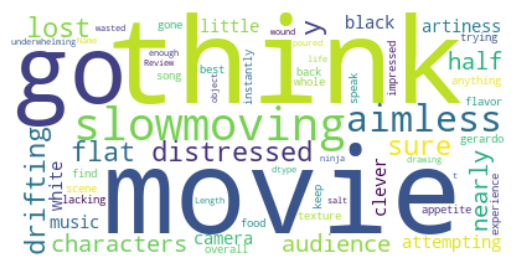

In [358]:
cloud= WordCloud(background_color='white').generate(str(df.Review))
plt.imshow(cloud, interpolation='bilinear')  
plt.axis('off')
# Display the figure
plt.show()

In [299]:
df['review_token'] = df['Review'].apply(lambda x: word_tokenize(x))



In [300]:
vocab_size=len(df['review_token']) +1
print(vocab_size)

2749


In [301]:
#find min, max, avg length of reviews after processing
df.length_review=df.review_token.str.len()
max(df.length_review)

782

In [302]:
min(df.length_review)

1

In [303]:
statistics.mean(df.length_review)

6.74235807860262

In [304]:
statistics.median(df.length_review)

5.0

<AxesSubplot:xlabel='Length'>

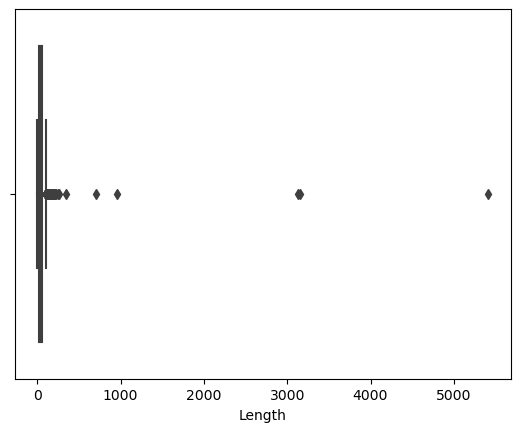

In [305]:
df['Length']= df['Review'].str.len()
sns.boxplot(x=df['Length'])

In [306]:
df1 = df[df['Review'].str.len() <= 325]

print(df1)


                                                Review  Rating  \
0    slowmoving aimless movie distressed drifting y...       0   
1    sure lost flat characters audience nearly half...       0   
2    attempting artiness black white clever camera ...       0   
3                          little music anything speak       0   
4    best scene movie gerardo trying find song keep...       1   
..                                                 ...     ...   
995                  think food flavor texture lacking       0   
996                            appetite instantly gone       0   
997                    overall impressed would go back       0   
998  whole experience underwhelming think go ninja ...       0   
999  wasted enough life poured salt wound drawing t...       0   

                                          review_token  Length  
0    [slowmoving, aimless, movie, distressed, drift...      54  
1    [sure, lost, flat, characters, audience, nearl...      53  
2    [attemp

<AxesSubplot:xlabel='Review'>

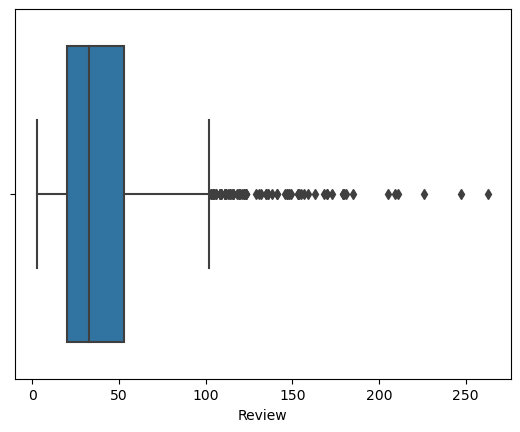

In [307]:
sns.boxplot(x=df1['Review'].str.len())

In [308]:
max_length = 15
df['review_token'] = df['review_token'].apply(lambda x: x[:max_length] if len(x) > max_length else x + [''] * (max_length - len(x)))

In [331]:
max_length = 15
df['review_token'] = df['review_token'].apply(lambda x: x[:max_length] if len(x) > max_length else x + [''] * (max_length - len(x)))




In [361]:
print(' '.join(df['review_v'].str.split().str[:17].apply(' '.join)[0]))

slowmoving aimless movie distressed drifting young man way plug us unless go converter wow loved place


In [309]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [326]:

df['review_v'] = df['review_token'].apply(lambda x: ' '.join(x))

# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the 'Review_token' column
vectorized_reviews = vectorizer.fit_transform(df['review_v'])


In [336]:
tensor = tf.convert_to_tensor(V_features)

In [332]:
target=df['Rating']

In [365]:
X = tensor
y = target

# Convert TensorFlow tensors to NumPy arrays
X_np = X.numpy()
y_np = np.array(y)

# Split data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Convert NumPy arrays back to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train)
X_val = tf.convert_to_tensor(X_val)
X_test = tf.convert_to_tensor(X_test)


In [366]:
original_size = 1000
test_size = int(original_size * 0.2)
train_val_size = int(original_size * 0.8)
train_size = int(train_val_size * 0.8)  # 80% of the train_val_size
val_size = train_val_size - train_size  # Remaining 20% of the train_val_size

print("Test set size:", test_size)
print("Train set size:", train_size)
print("Validation set size:", val_size)


Test set size: 200
Train set size: 640
Validation set size: 160


In [342]:
model = Sequential()
model.add(Dense(units=2749, activation='relu')) #nodes=vocab size
model.add(Dense(units=1533, activation='relu')) #nodes = 2/3 input node size
model.add(Dense(units=533, activation='relu')) #nodes= above layer - 1000
model.add(Dense(units=267, activation='relu')) #nodes = 1/2 above layer
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [343]:
# Train your model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Evaluate the model on the testing set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

Epoch 1/25
440/440 [==============================] - 67s 150ms/step - loss: 0.5471 - accuracy: 0.7175
Epoch 2/25
440/440 [==============================] - 68s 154ms/step - loss: 0.1393 - accuracy: 0.9550
Epoch 3/25
440/440 [==============================] - 67s 153ms/step - loss: 0.0361 - accuracy: 0.9873
Epoch 4/25
440/440 [==============================] - 71s 161ms/step - loss: 0.0209 - accuracy: 0.9945
Epoch 5/25
440/440 [==============================] - 73s 167ms/step - loss: 0.0148 - accuracy: 0.9950
Epoch 6/25
440/440 [==============================] - 75s 170ms/step - loss: 0.0128 - accuracy: 0.9959
Epoch 7/25
440/440 [==============================] - 75s 170ms/step - loss: 0.0101 - accuracy: 0.9945
Epoch 8/25
440/440 [==============================] - 75s 171ms/step - loss: 0.0234 - accuracy: 0.9923
Epoch 9/25
440/440 [==============================] - 75s 170ms/step - loss: 0.0158 - accuracy: 0.9950
Epoch 10/25
440/440 [==============================] - 75s 171ms/step - l

In [344]:
print(model.summary())

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_99 (Dense)            (None, 2749)              12969782  
                                                                 
 dense_100 (Dense)           (None, 1533)              4215750   
                                                                 
 dense_101 (Dense)           (None, 533)               817622    
                                                                 
 dense_102 (Dense)           (None, 267)               142578    
                                                                 
 dense_103 (Dense)           (None, 1)                 268       
                                                                 
Total params: 18,146,000
Trainable params: 18,146,000
Non-trainable params: 0
_________________________________________________________________
None


In [345]:
print(X_train.shape)

(2198, 4717)


In [346]:
print(y_train)

[1 1 1 ... 0 0 1]


In [347]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 79.27%


In [351]:
from sklearn.metrics import mean_squared_error

# Assuming you have trained your model and obtained predictions
y_pred = model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mse)

18/18 [==============================] - 0s 15ms/step
Mean Squared Error: 0.19586398049585652


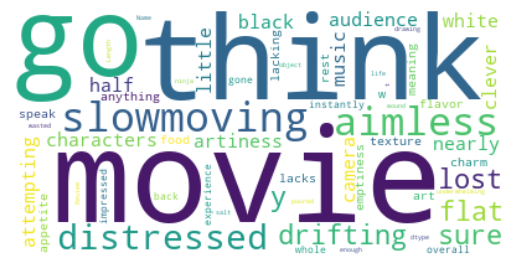

In [350]:
filtered_df1 = df1[df1['Rating'] == 0].copy()
cloud = WordCloud(background_color='white').generate(str(filtered_df1.Review))
plt.imshow(cloud, interpolation='bilinear')  
plt.axis('off')
# Display the figure
plt.show()